In [1]:
import bin.accretion_definitions as defs
import numpy as np
import bin.utils as utils
from IPython.display import Math
import matplotlib.pyplot as plt

/home/jlm/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
M = 1e6 * defs.Msun 
q = 0.9
lambda_tot = 0.1
sep = 100 * defs.grav_radius(M)
i = 30 * np.pi/180
a = [0.99, 0.99]
h = [10, 10] #rg
f = 0 * np.pi/180

In [7]:
class Binary(object):
    def __init__(self, Mass, mass_ratio, lambda_tot, separation, inclination, spin, coronal_height, phase, redshift):
        self.M = Mass
        self.q = mass_ratio
        self.lambda_tot = lambda_tot

        self.sep = separation * defs.grav_radius(self.M)
        self.i   = inclination
        self.a   = spin
        self.h   = coronal_height
        self.f   = phase

        self.z   = redshift

    def calculate(self):
        
        self.m1,self.m2,_,_,_, self.lambda_1, _, self.lambda_2 = defs.get_all_mdot(self.lambda_tot,self.q,self.M)

        rin1, rin2   = defs.rms_real_units(self.a[0], self.m1), defs.rms_real_units(self.a[1], self.m2)
        rg1, rg2     = defs.grav_radius(self.m1), defs.grav_radius(self.m2)
        rout1, rout2 = defs.truncated_rout(self.sep, self.q)

        self.rin  = [rin1, rin2]
        self.rg   = [rg1, rg2]
        self.rout = [rout1, rout2]        

        print("Computing orbit...")

        v1, v2 = defs.velocities(self.M,self.sep,self.q)
        self.v = [v1, v2]
        z1, z2 = defs.orbital_redshift(v1, phase=self.f, incl=self.i), defs.orbital_redshift(v2, phase=self.f, incl=self.i)
        self.z_orb = [z1, z2]

        print("Now computing ionization...")

        xi_1 = defs.get_xi(self.h[0],self.a[0],loglambda_edd=np.log10(self.lambda_1), relxill_bound=False )
        xi_2 = defs.get_xi(self.h[1],self.a[1],loglambda_edd=np.log10(self.lambda_2), relxill_bound=False )
        self.xi = [xi_1, xi_2]

        print("Now computing Luminosity and Flux...")

        self.dL = defs.luminosity_distance(self.z) * 3.09e22 #m/Mpc
        L1 = defs.Eddington_luminosity(self.m1) * self.lambda_1
        L2 = defs.Eddington_luminosity(self.m2) * self.lambda_2
        self.L = [L1, L2]

        Fx1 = defs.Xray_flux(m=self.m1, dL=self.dL, lambda_= self.lambda_1)
        Fx2 = defs.Xray_flux(m=self.m2, dL=self.dL, lambda_= self.lambda_2)
        self.Fx = [Fx1, Fx2]
        # note that xspec cflux asks for log10(F)

        print("All done calculating.")
        
    
    def print_mass(self): # type: ignore
        display(Math('M'+  utils.print_to_latex(self.M/defs.Msun, unit='M_\odot')))
        display(Math('m_1'+utils.print_to_latex(self.m1/defs.Msun, unit='M_\odot')))
        display(Math('m_2'+utils.print_to_latex(self.m2/defs.Msun, unit='M_\odot')))
        return

    def print_lambda_xi(self):
        display(Math(r'\lambda_{tot}'+r' = {:.2f}'.format(self.lambda_tot)))
        display(Math(r'\lambda_{1}'+r'\; = {:.2f}'.format(self.lambda_1)))
        display(Math(r'\lambda_{2}'+r'\; = {:.2f}'.format(self.lambda_2)))
        display(Math(r'{\rm log}_{10} \; \xi_1 \;' + '= {:.2f}'.format(np.log10(self.xi[0]))))
        display(Math(r'{\rm log}_{10} \; \xi_2 \;' + '= {:.2f}'.format(np.log10(self.xi[1]))))
        return

    def print_radii(self):
        display(Math(r'r_{g(1)} \; \;'+ utils.print_to_latex(self.rg[0], unit=r'{\rm km}')))
        display(Math(r'r_{g(2)} \; \;'+ utils.print_to_latex(self.rg[1], unit=r'{\rm km}')))
        display(Math(r'r_{in(1)} \;'+   utils.print_to_latex(self.rin[0]/self.rg[0], unit='r_g')+  utils.print_to_latex(self.rin[0], unit=r'{\rm m}')))
        display(Math(r'r_{in(2)} \;'+   utils.print_to_latex(self.rin[1]/self.rg[1], unit='r_g')+  utils.print_to_latex(self.rin[1], unit=r'{\rm m}')))
        display(Math(r'r_{out(1)}'+     utils.print_to_latex(self.rout[0]/self.rg[0], unit='r_g')+ utils.print_to_latex(self.rout[0], unit=r'{\rm m}')))
        display(Math(r'r_{out(2)}'+     utils.print_to_latex(self.rout[1]/self.rg[1], unit='r_g')+ utils.print_to_latex(self.rout[1], unit=r'{\rm m}')))
        return

    def print_orbit(self):
        display(Math(r'v_{orb(1)} \;' + utils.print_to_latex(self.v[0],unit='m/s') + r'= {:.2f}'.format(self.v[0]/defs.c * 100) + r'\% {\rm \; of \; c}'))
        display(Math(r'v_{orb(2)} \;' + utils.print_to_latex(self.v[1],unit='m/s') + r'= {:.2f}'.format(self.v[1]/defs.c * 100) + r'\% {\rm \; of \; c}'))
        display(Math(r'z_{orb(1)} \;'+r' = {:.5f}'.format(self.z_orb[0])))
        display(Math(r'z_{orb(2)} \;'+r' = {:.5f}'.format(self.z_orb[1])))
        return
    
    def print_lumin(self):
        display(Math(r'd_L \;'+      utils.print_to_latex(self.dL/3.09e22, unit=r'{\rm Mpc}') + utils.print_to_latex(self.dL, unit=r'{\rm m}')))
        display(Math(r'L_1 \;' +     utils.print_to_latex(self.L[0], unit=r'{\rm erg/s}')))
        display(Math(r'L_2 \;' +     utils.print_to_latex(self.L[1], unit=r'{\rm erg/s}')))
        display(Math(r'F_{x,1} \;' + utils.print_to_latex(self.Fx[0], unit=r'{\rm erg/s/cm^2}')+r', \; {\rm log_{10}} F_{x,1} \;' + '= {:.2f}'.format(np.log10(self.Fx[0]))))
        display(Math(r'F_{x,2} \;' + utils.print_to_latex(self.Fx[1], unit=r'{\rm erg/s/cm^2}')+r', \; {\rm log_{10}} F_{x,2} \;' + '= {:.2f}'.format(np.log10(self.Fx[1]))))
        return
    
    def print_all(self):
        self.print_mass()
        self.print_lambda_xi()
        self.print_radii()
        self.print_orbit()
        self.print_lumin()

        return

In [8]:
binary = Binary(Mass = 1e6 * defs.Msun, 
                mass_ratio = 0.9, 
                lambda_tot = 0.1,
                separation = 100, 
                inclination = 30 * np.pi/180,
                spin = [0.99, 0.99],
                coronal_height = [10, 10], #rg
                phase = 90 * np.pi/180,
                redshift = 0.1)

Binary.calculate(binary)
Binary.print_all(binary)

Computing orbit...
Now computing ionization...
Now computing Luminosity and Flux


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [16]:
binary_6 = Binary(Mass = 1e6 * defs.Msun, 
                  mass_ratio = 0.9, 
                  lambda_tot = 0.1,
                  separation = 100, 
                  inclination = 30 * np.pi/180,
                  spin = [0.99, 0.99],
                  coronal_height = [10, 10], #rg
                  phase = 90 * np.pi/180,
                  redshift = 1.0)
binary_9 = Binary(Mass = 1e9 * defs.Msun, 
                  mass_ratio = 0.9, 
                  lambda_tot = 0.1,
                  separation = 100, 
                  inclination = 30 * np.pi/180,
                  spin = [0.99, 0.99],
                  coronal_height = [10, 10], #rg
                  phase = 90 * np.pi/180,
                  redshift = 1.0)
Binary.calculate(binary_6)
Binary.calculate(binary_9)

Computing orbit...
Now computing ionization...
Now computing Luminosity and Flux
Computing orbit...
Now computing ionization...
Now computing Luminosity and Flux


In [20]:
flux10 = np.log10(binary_9.Fx[1])
print('{:.2f}'.format(flux10))

-13.20


In [29]:
lambdas = np.logspace(-2,0)
masses = np.logspace(5,10)
lumins = np.logspace(6,14)


bol_lambda = defs.bolometric_correction(func='eddratio',value=lambdas)
bol_masses = defs.bolometric_correction(func='mass',value=masses)
bol_lumins = defs.bolometric_correction(func='lumin',value=lumins)

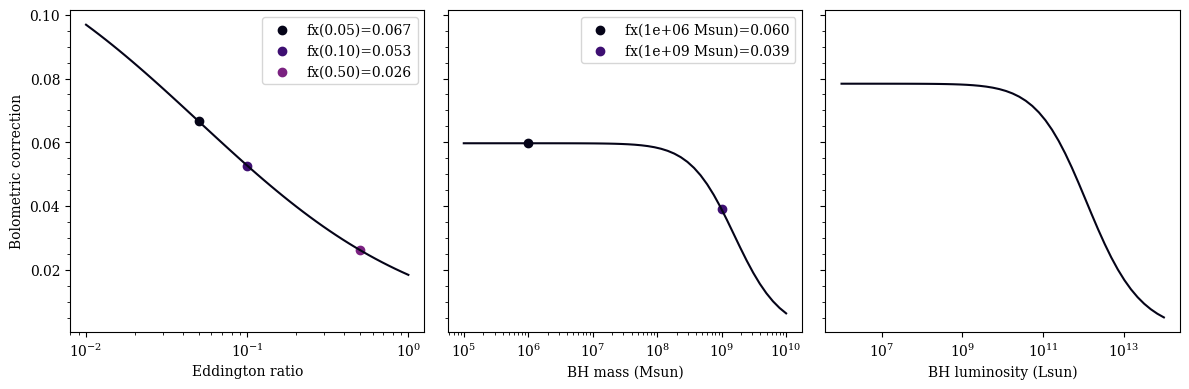

In [30]:
fig, [ax1,ax2,ax3] = plt.subplots(1, 3, sharey=True, figsize=(12,4))
ax1.plot(lambdas,bol_lambda)
ax2.plot(masses, bol_masses)
ax3.plot(lumins, bol_lumins)
ax2.set_xscale('log')
ax1.set_xscale('log')
ax3.set_xscale('log')
ax1.set_xlabel('Eddington ratio')
ax2.set_xlabel('BH mass (Msun)')
ax3.set_xlabel('BH luminosity (Lsun)')
ax1.set_ylabel('Bolometric correction')

for xx in [0.05, 0.1, 0.5]:
    yy = defs.bolometric_correction(func='eddratio',value=xx)
    ax1.scatter(xx,yy, label = 'fx({:.2f})={:.3f}'.format(xx,yy))
ax1.legend(loc='best')

for xx in [1e6, 1e9]:
    yy = defs.bolometric_correction(func='mass',value=xx)
    ax2.scatter(xx,yy, label = 'fx({:.0e} Msun)={:.3f}'.format(xx,yy))
ax2.legend(loc='best')

plt.tight_layout()
# iomization script uses eddington
# Duras warns that other authors have found correlation between fx and lambda or M, though with huge scatter
# not viable for lambda < 10^-2 because they have no sources in this regime -> our lowest is 5%

In [ ]:
display(Math(r'\lambda_1=0.09 =>'+'{:.4f}'.format(defs.bolometric_correction(func='eddratio',value=0.09))))
display(Math(r'\lambda_2=0.11 =>'+'{:.4f}'.format(defs.bolometric_correction(func='eddratio',value=0.11))))
display(Math(r'M=10^6 => m_1 = 5.26 \cdot 10^5 =>'+'{:.4f}'.format(defs.bolometric_correction(func='mass',value=5.26e5))))
display(Math(r'M=10^6 => m_2 = 4.74 \cdot 10^5 =>'+'{:.4f}'.format(defs.bolometric_correction(func='mass',value=4.74e5))))
display(Math(r'M=10^9 => m_1 = 5.26 \cdot 10^8 =>'+'{:.4f}'.format(defs.bolometric_correction(func='mass',value=5.26e8))))
display(Math(r'M=10^9 => m_2 = 4.74 \cdot 10^8 =>'+'{:.4f}'.format(defs.bolometric_correction(func='mass',value=4.74e8))))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [2]:
m1,m2,ltot,l1,l2 = defs.get_all_edd(fixed_lambda_tot=0.1,q=0.9,M=10**6 * defs.Msun)
defs.Xray_flux(m=m1,dL=,lambda_=l1)